**GITHUB:**

**Part1:Step1. Load the Fashion MNIST dataset**

In [1]:
import torch
import torchvision
from torchvision.transforms import ToTensor, Normalize, Compose
from torchvision.datasets import FashionMNIST
dataset = torchvision.datasets.FashionMNIST(root='data',
                                            train=True,
                                            download=True,
                                            transform=Compose([ToTensor(),Normalize([0.5, ], [0.5, ])]))

100%|██████████| 26421880/26421880 [00:01<00:00, 15556327.81it/s]


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 269287.32it/s]


Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:00<00:00, 4872979.06it/s]


Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 4833731.14it/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# have a look at the tensor of sample of fashion mnist dataset
img, label = dataset[0]
print('Label: ', label)
# [:, 10:15, 10:15] means selecting all the channels of the image, the image is 28*28, we select the rows and columns from 10 to 14
print(img[:,10:15,10:15])
torch.min(img), torch.max(img)

Label:  9
tensor([[[-1.0000, -1.0000, -1.0000,  0.5137,  0.7882],
         [-0.9765, -1.0000, -0.9059,  0.7176,  0.7255],
         [-0.9529, -1.0000, -0.2235,  0.9137,  0.7412],
         [-1.0000, -1.0000, -0.5686,  0.8510,  0.7882],
         [-1.0000, -1.0000,  0.8588,  0.7725,  0.7020]]])


(tensor(-1.), tensor(1.))

In [4]:
from torch.utils.data import DataLoader
# Batch size during training
batch_size = 100
data_loader = DataLoader(dataset, batch_size, shuffle=True)

In [5]:
# class name of fashion minist dataset
class_names = {
    0: "T-shirt/top",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle boot"
}

first batch
torch.Size([100, 1, 28, 28])
tensor([8, 6, 8, 9, 3, 8, 4, 9, 9, 7, 1, 9, 0, 2, 4, 6, 6, 3, 4, 6, 1, 2, 4, 4,
        7, 5, 7, 3, 6, 1, 8, 0, 8, 1, 6, 4, 6, 9, 2, 9, 8, 6, 8, 1, 6, 2, 4, 1,
        6, 8, 7, 9, 5, 7, 3, 5, 0, 6, 9, 4, 3, 9, 7, 9, 2, 3, 9, 7, 6, 9, 1, 1,
        3, 6, 2, 2, 3, 4, 8, 0, 6, 4, 9, 0, 4, 1, 1, 0, 7, 9, 1, 8, 0, 7, 9, 0,
        0, 6, 2, 6])
Label: Bag


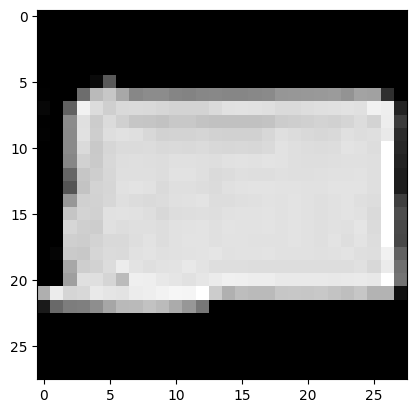

In [6]:
for img_batch, label_batch in data_loader:
    print('first batch')
    print(img_batch.shape)
    plt.imshow(img_batch[0][0], cmap='gray')
    print(label_batch)
    class_label = label_batch[0]
    print(f'Label: {class_names[class_label.item()]}')
    break

In [7]:
# Decide which device we want to run on
#device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

**Step2. Train the GAN model to produce images in this new domain**

In [8]:
# Number of channels in the training images. For gray images this is 1
nc = 1
# Size of generator input
latent_size = nz = 64
# Size of feature maps in generator
ngf = 8
# Size of feature maps in discriminator
ndf = 8

In [9]:
import torch
import torch.nn as nn

# Define the Generator
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d(nz, ngf * 8, kernel_size=7, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 7 x 7
            nn.ConvTranspose2d(ngf * 8, ngf * 4, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 14 x 14
            nn.ConvTranspose2d(ngf * 4, ngf * 2, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 28 x 28
            nn.ConvTranspose2d(ngf * 2, nc, kernel_size=3, stride=1, padding=1, bias=False),
            nn.Tanh()
            # state size. (nc) x 28 x 28
        )

    def forward(self, input):
        return self.main(input)

In [10]:
# Create the generator
netG = Generator().to(device)
print(netG)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(64, 64, kernel_size=(7, 7), stride=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(32, 16, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(16, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (10): Tanh()
  )
)


In [11]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            # input is (nc) x 28 x 28
            nn.Conv2d(nc, ndf, kernel_size=3, stride=2, padding=1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 14 x 14
            nn.Conv2d(ndf, ndf * 2, kernel_size=3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 7 x 7
            nn.Conv2d(ndf * 2, 1, kernel_size=7, stride=1, padding=0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [12]:
# Create the Discriminator
netD = Discriminator().to(device)

# Apply the ``weights_init`` function to randomly initialize all weights
# like this: ``to mean=0, stdev=0.2``.
#netD.apply(weights_init)

# Print the model
print(netD)

Discriminator(
  (main): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(16, 1, kernel_size=(7, 7), stride=(1, 1), bias=False)
    (6): Sigmoid()
  )
)


In [13]:
import os
import random
import torch
import torchvision.transforms as transforms
import numpy as np

In [14]:
criterion = nn.BCELoss()
d_optimizer = torch.optim.Adam(netD.parameters(), lr=0.0002)
g_optimizer = torch.optim.Adam(netG.parameters(), lr=0.0002)

In [15]:
def reset_grad():
    d_optimizer.zero_grad()
    g_optimizer.zero_grad()

def train_discriminator(images):
    # Create the labels which are later used as input for the BCE loss
    real_labels = torch.ones(batch_size, 1, 1, 1).to(device)
    fake_labels = torch.zeros(batch_size, 1, 1, 1).to(device)

    # Loss for real images
    outputs = netD(images)
    d_loss_real = criterion(outputs, real_labels)
    real_score = outputs

    # Loss for fake images
    z = torch.randn(batch_size, latent_size,1,1).to(device)
    fake_images = netG(z)
    outputs = netD(fake_images)
    d_loss_fake = criterion(outputs, fake_labels)
    fake_score = outputs

    # Combine losses
    d_loss = d_loss_real + d_loss_fake
    # Reset gradients
    reset_grad()
    # Compute gradients
    d_loss.backward()
    # Adjust the parameters using backprop
    d_optimizer.step()

    return d_loss, real_score, fake_score

In [16]:

def train_generator():
    # Generate fake images and calculate loss
    z = torch.randn(batch_size, latent_size,1,1).to(device)
    fake_images = netG(z)
    labels = torch.ones(batch_size, 1, 1, 1).to(device)
    g_loss = criterion(netD(fake_images), labels)

    # Backprop and optimize
    reset_grad()
    g_loss.backward()
    g_optimizer.step()
    return g_loss, fake_images

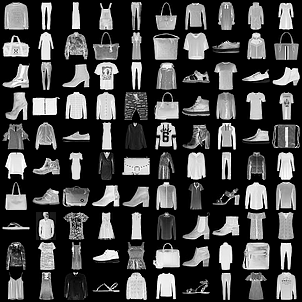

In [18]:
def denorm(x):
    out = (x + 1) / 2
    return out.clamp(0, 1)
import os

sample_dir = '/content/sample_data/samples'
from IPython.display import Image
from torchvision.utils import save_image

# Save some real images
for images, _ in data_loader:
    #images = images.reshape(images.size(0), 1, 28, 28)
    save_image(denorm(images), os.path.join(sample_dir, 'real_images.png'), nrow=10)
    break

Image(os.path.join(sample_dir, 'real_images.png'))

Saving fake_images-0000.png


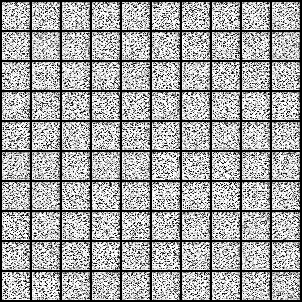

In [19]:
# Create the noise as the input of the generator
sample_vectors = torch.randn(batch_size, latent_size,1,1).to(device)

# define the function to save the generator
def save_fake_images(index):
    fake_images = netG(sample_vectors)
    fake_fname = 'fake_images-{0:0=4d}.png'.format(index)
    print('Saving', fake_fname)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=10)

# Before training
save_fake_images(0)
# have a look at the generated fake image
Image(os.path.join(sample_dir, 'fake_images-0000.png'))

In [ ]:
# train the DCGAN generator
%%time

num_epochs = 10
total_step = len(data_loader)
d_losses, g_losses, real_scores, fake_scores = [], [], [], []

for epoch in range(num_epochs):
    for i, (images, _) in enumerate(data_loader):
        # Train the discriminator and generator
        d_loss, real_score, fake_score = train_discriminator(images)
        g_loss, fake_images = train_generator()

        # Inspect the losses
        if (i+1) % 200 == 0:
            d_losses.append(d_loss.item())
            g_losses.append(g_loss.item())
            real_scores.append(real_score.mean().item())
            fake_scores.append(fake_score.mean().item())
            print('Epoch [{}/{}], Step [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}, D(x): {:.2f}, D(G(z)): {:.2f}'
                  .format(epoch, num_epochs, i+1, total_step, d_loss.item(), g_loss.item(),
                          real_score.mean().item(), fake_score.mean().item()))

    # Sample and save images
    save_fake_images(epoch+1)

Epoch [0/10], Step [200/600], d_loss: 1.5946, g_loss: 0.5731, D(x): 0.48, D(G(z)): 0.57
Epoch [0/10], Step [400/600], d_loss: 1.5297, g_loss: 0.6551, D(x): 0.48, D(G(z)): 0.54
Epoch [0/10], Step [600/600], d_loss: 1.3961, g_loss: 0.7568, D(x): 0.51, D(G(z)): 0.50
Saving fake_images-0001.png
Epoch [1/10], Step [200/600], d_loss: 1.6606, g_loss: 0.6825, D(x): 0.41, D(G(z)): 0.52
Epoch [1/10], Step [400/600], d_loss: 1.6849, g_loss: 0.6394, D(x): 0.41, D(G(z)): 0.54
Epoch [1/10], Step [600/600], d_loss: 1.4151, g_loss: 0.7694, D(x): 0.47, D(G(z)): 0.48
Saving fake_images-0002.png
Epoch [2/10], Step [200/600], d_loss: 1.1711, g_loss: 0.8943, D(x): 0.55, D(G(z)): 0.43
Epoch [2/10], Step [400/600], d_loss: 1.3217, g_loss: 0.8715, D(x): 0.48, D(G(z)): 0.43
Epoch [2/10], Step [600/600], d_loss: 1.6247, g_loss: 0.6522, D(x): 0.44, D(G(z)): 0.53
Saving fake_images-0003.png
Epoch [3/10], Step [200/600], d_loss: 1.4768, g_loss: 0.7040, D(x): 0.48, D(G(z)): 0.50
Epoch [3/10], Step [400/600], d_loss

**Step3. Save and display at least 3 samples produced from your GAN model**

**Step4. Save the model weights in the folder to be used later.**

In [ ]:
# Save the model checkpoints
EPOCH = 10

torch.save({
            'epoch': EPOCH,
            'model_state_dict': netD.state_dict(),
            'optimizer_state_dict': d_optimizer.state_dict(),
            }, '/content/sample_data/netD')

torch.save({
            'epoch': EPOCH,
            'model_state_dict': netG.state_dict(),
            'optimizer_state_dict': g_optimizer.state_dict(),
            }, '/content/sample_data/netG')

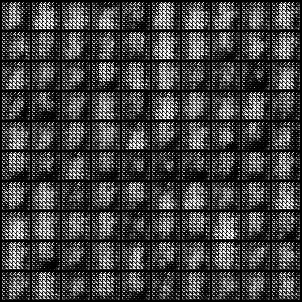

In [ ]:
Image('/content/sample_data/samples/fake_images-0001.png')

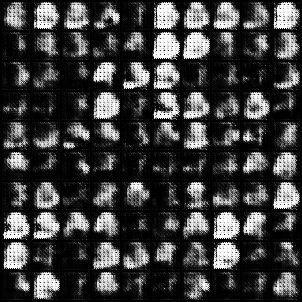

In [ ]:
Image('/content/sample_data/samples/fake_images-0005.png')

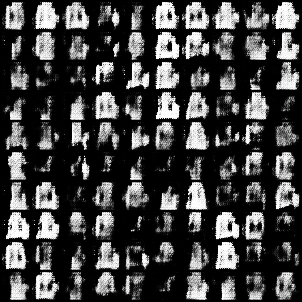

In [ ]:
Image('/content/sample_data/samples/fake_images-0009.png')

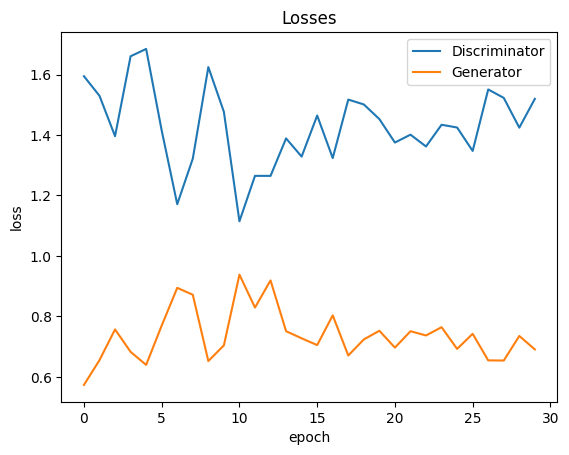

In [ ]:
plt.plot(d_losses, '-')
plt.plot(g_losses, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');

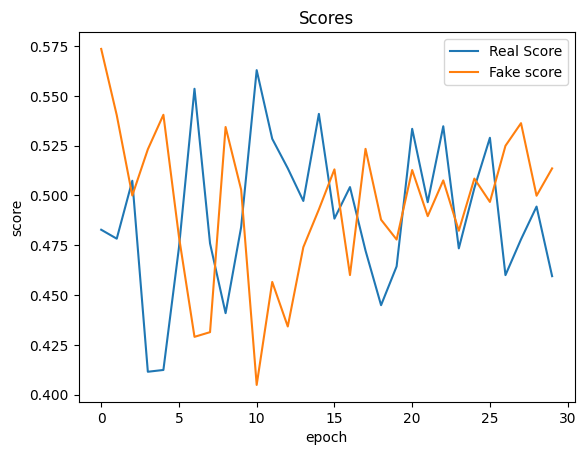

In [ ]:
plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real Score', 'Fake score'])
plt.title('Scores');

**Difficulties faced in this process**

Compared with the GAN, which uses a simple feedforward neural network as both the generator and discriminator, the DCGAN, which uses a CNN for both generator and discriminator,it turns out for the same number of epochs, DCGAN generates higher quality fake images. However, the training time for DCGAN significantly increases, especially when the number of feature maps is large.
The quality of fake images improves as the number of epochs increases. Additionally, the hyperparameter tunning of CNN descriminator and generatorbut needs lots of experiments, it requires more time and gpu resource. With limited resources, it's hard for the DCGAN to generate sufficiently satisfying 'real images'.

**Step5. Load the model using the saved weights.**

In [ ]:

# Load the checkpoint
checkpoint_d = torch.load('/content/sample_data/netD')
netD.load_state_dict(checkpoint_d['model_state_dict'])
checkpoint_g = torch.load('/content/sample_data/netG')
netG.load_state_dict(checkpoint_g['model_state_dict'])

<All keys matched successfully>

**Step 6: Re-train the GAN model to see the performance.**

In [ ]:

netD.train()
netG.train()

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(64, 64, kernel_size=(7, 7), stride=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(32, 16, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(16, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (10): Tanh()
  )
)

In [ ]:
%%time

num_epochs = 10
total_step = len(data_loader)
d_losses, g_losses, real_scores, fake_scores = [], [], [], []

for epoch in range(num_epochs):
    for i, (images, _) in enumerate(data_loader):
        # Train the discriminator and generator
        d_loss, real_score, fake_score = train_discriminator(images)
        g_loss, fake_images = train_generator()

        # Inspect the losses
        if (i+1) % 200 == 0:
            d_losses.append(d_loss.item())
            g_losses.append(g_loss.item())
            real_scores.append(real_score.mean().item())
            fake_scores.append(fake_score.mean().item())
            print('Epoch [{}/{}], Step [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}, D(x): {:.2f}, D(G(z)): {:.2f}'
                  .format(epoch, num_epochs, i+1, total_step, d_loss.item(), g_loss.item(),
                          real_score.mean().item(), fake_score.mean().item()))

    # Sample and save images
    fake_images = netG(sample_vectors)
    fake_fname = 'fake_images-{0:0=4d}.png'.format(epoch+1)
    print('Saving', fake_fname)
    save_image(denorm(fake_images), os.path.join('/content/sample_data/retrain_samples', fake_fname), nrow=10)

Epoch [0/10], Step [200/600], d_loss: 1.4023, g_loss: 0.6888, D(x): 0.52, D(G(z)): 0.52
Epoch [0/10], Step [400/600], d_loss: 1.4375, g_loss: 0.7314, D(x): 0.49, D(G(z)): 0.50
Epoch [0/10], Step [600/600], d_loss: 1.4443, g_loss: 0.7176, D(x): 0.48, D(G(z)): 0.50
Saving fake_images-0001.png
Epoch [1/10], Step [200/600], d_loss: 1.5103, g_loss: 0.6679, D(x): 0.49, D(G(z)): 0.53
Epoch [1/10], Step [400/600], d_loss: 1.2739, g_loss: 0.7742, D(x): 0.54, D(G(z)): 0.47
Epoch [1/10], Step [600/600], d_loss: 1.3220, g_loss: 0.7602, D(x): 0.52, D(G(z)): 0.48
Saving fake_images-0002.png
Epoch [2/10], Step [200/600], d_loss: 1.3740, g_loss: 0.6944, D(x): 0.51, D(G(z)): 0.50
Epoch [2/10], Step [400/600], d_loss: 1.3958, g_loss: 0.7028, D(x): 0.50, D(G(z)): 0.49
Epoch [2/10], Step [600/600], d_loss: 1.4593, g_loss: 0.6663, D(x): 0.49, D(G(z)): 0.52
Saving fake_images-0003.png
Epoch [3/10], Step [200/600], d_loss: 1.4150, g_loss: 0.6933, D(x): 0.49, D(G(z)): 0.50
Epoch [3/10], Step [400/600], d_loss

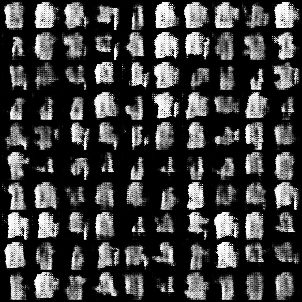

In [ ]:
Image('/content/sample_data/retrain_samples/fake_images-0001.png')

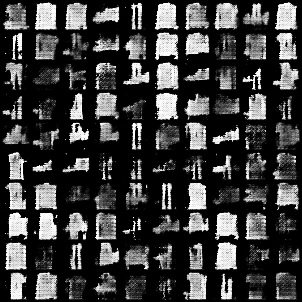

In [ ]:
Image('/content/sample_data/retrain_samples/fake_images-0010.png')

In [ ]:
torch.save(netG.state_dict(), '/content/sample_data/retrain_netG')
torch.save(netD.state_dict(), '/content/sample_data/retrain_netD')

**Compared with the initial training, the losses of both the generator and discriminator decrease. And from the fake images generated by the retrained DCGAN model, we can see that it produces images more similar to the real ones.**

**Part 2 LSGAN**

In [20]:
# change the loss function in discriminator
def train_discriminator(images):
    # Create the labels which are later used as input for the BCE loss
    real_labels = torch.ones(batch_size, 1, 1, 1).to(device)
    fake_labels = torch.zeros(batch_size, 1, 1, 1).to(device)

    # Loss for real images
    outputs = netD(images)
    real_score = outputs

    # Loss for fake images
    z = torch.randn(batch_size, latent_size,1,1).to(device)
    fake_images = netG(z)
    outputs = netD(fake_images)
    fake_score = outputs

    # Combine losses
    d_loss = 0.5 * (torch.mean((real_score - 1)**2) + torch.mean(fake_score**2))
    # Reset gradients
    reset_grad()
    # Compute gradients
    d_loss.backward()
    # Adjust the parameters using backprop
    d_optimizer.step()

    return d_loss, real_score, fake_score

In [21]:
# change the loss in generator
def train_generator():
    # Generate fake images and calculate loss
    z = torch.randn(batch_size, latent_size,1,1).to(device)
    fake_images = netG(z)
    fake_score = netD(fake_images)
    g_loss = 0.5 * torch.mean((fake_score - 1)**2)
    # Backprop and optimize
    reset_grad()
    g_loss.backward()
    g_optimizer.step()
    return g_loss, fake_images

In [23]:
# train the model
num_epochs = 10
total_step = len(data_loader)
d_losses, g_losses, real_scores, fake_scores = [], [], [], []
netD.train()
netG.train()
for epoch in range(num_epochs):
    for i, (images, _) in enumerate(data_loader):
        # Train the discriminator and generator
        d_loss, real_score, fake_score = train_discriminator(images)
        g_loss, fake_images = train_generator()

        # Inspect the losses
        if (i+1) % 200 == 0:
            d_losses.append(d_loss.item())
            g_losses.append(g_loss.item())
            real_scores.append(real_score.mean().item())
            fake_scores.append(fake_score.mean().item())
            print('Epoch [{}/{}], Step [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}, D(x): {:.2f}, D(G(z)): {:.2f}'
                  .format(epoch+1, num_epochs, i+1, total_step, d_loss.item(), g_loss.item(),
                          real_score.mean().item(), fake_score.mean().item()))

    # Sample and save images
    fake_images = netG(sample_vectors)
    fake_fname = 'fake_images-{0:0=4d}.png'.format(epoch+1)
    print('Saving', fake_fname)
    save_image(denorm(fake_images), os.path.join('/content/sample_data/LSGAN', fake_fname), nrow=10)

Epoch [1/10], Step [200/600], d_loss: 0.0604, g_loss: 0.3262, D(x): 0.73, D(G(z)): 0.20
Epoch [1/10], Step [400/600], d_loss: 0.3218, g_loss: 0.0983, D(x): 0.47, D(G(z)): 0.58
Epoch [1/10], Step [600/600], d_loss: 0.1496, g_loss: 0.2206, D(x): 0.63, D(G(z)): 0.38
Saving fake_images-0001.png
Epoch [2/10], Step [200/600], d_loss: 0.3486, g_loss: 0.1137, D(x): 0.39, D(G(z)): 0.54
Epoch [2/10], Step [400/600], d_loss: 0.3050, g_loss: 0.1320, D(x): 0.44, D(G(z)): 0.53
Epoch [2/10], Step [600/600], d_loss: 0.2432, g_loss: 0.1804, D(x): 0.49, D(G(z)): 0.45
Saving fake_images-0002.png
Epoch [3/10], Step [200/600], d_loss: 0.3653, g_loss: 0.0916, D(x): 0.38, D(G(z)): 0.57
Epoch [3/10], Step [400/600], d_loss: 0.2522, g_loss: 0.1379, D(x): 0.51, D(G(z)): 0.48
Epoch [3/10], Step [600/600], d_loss: 0.2700, g_loss: 0.1517, D(x): 0.43, D(G(z)): 0.46
Saving fake_images-0003.png
Epoch [4/10], Step [200/600], d_loss: 0.2636, g_loss: 0.1297, D(x): 0.49, D(G(z)): 0.50
Epoch [4/10], Step [400/600], d_loss

In [24]:
# Save the model checkpoints
EPOCH = 10

torch.save({
            'epoch': EPOCH,
            'model_state_dict': netD.state_dict(),
            'optimizer_state_dict': d_optimizer.state_dict(),
            }, '/content/sample_data/LSnetD')

torch.save({
            'epoch': EPOCH,
            'model_state_dict': netG.state_dict(),
            'optimizer_state_dict': g_optimizer.state_dict(),
            }, '/content/sample_data/LSnetG')

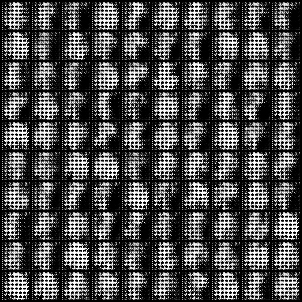

In [25]:
# show fake images generated by lsgan
Image('/content/sample_data/LSGAN/fake_images-0001.png')

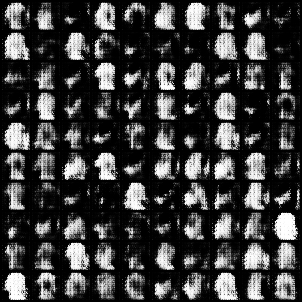

In [26]:
Image('/content/sample_data/LSGAN/fake_images-0005.png')

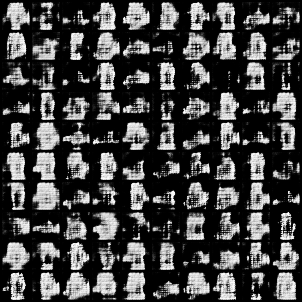

In [27]:
Image('/content/sample_data/LSGAN/fake_images-0010.png')

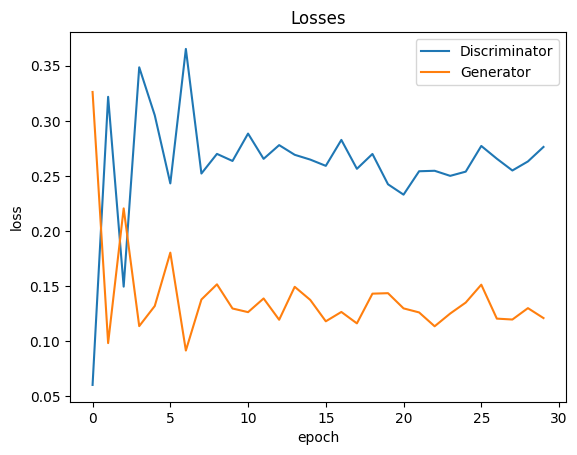

In [28]:
plt.plot(d_losses, '-')
plt.plot(g_losses, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');

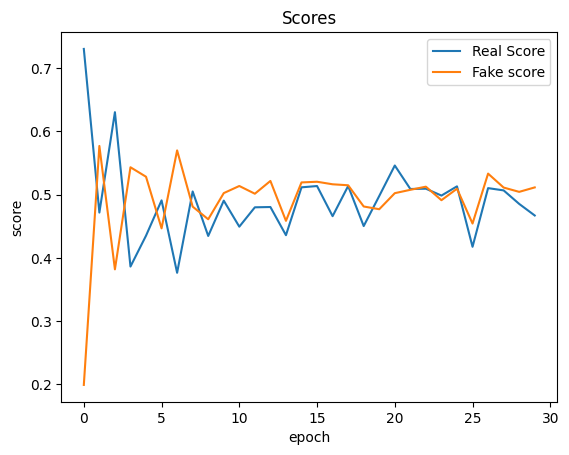

In [29]:
plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real Score', 'Fake score'])
plt.title('Scores');

In [30]:
# Load the checkpoint
checkpoint_d = torch.load('/content/sample_data/LSnetD')
netD.load_state_dict(checkpoint_d['model_state_dict'])
checkpoint_g = torch.load('/content/sample_data/LSnetG')
netG.load_state_dict(checkpoint_g['model_state_dict'])

<All keys matched successfully>

In [31]:
# Retrain the LSGAN
netD.train()
netG.train()

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(64, 64, kernel_size=(7, 7), stride=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(32, 16, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(16, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (10): Tanh()
  )
)

In [32]:
%%time

num_epochs = 10
total_step = len(data_loader)
d_losses, g_losses, real_scores, fake_scores = [], [], [], []

for epoch in range(num_epochs):
    for i, (images, _) in enumerate(data_loader):
        # Train the discriminator and generator
        d_loss, real_score, fake_score = train_discriminator(images)
        g_loss, fake_images = train_generator()

        # Inspect the losses
        if (i+1) % 200 == 0:
            d_losses.append(d_loss.item())
            g_losses.append(g_loss.item())
            real_scores.append(real_score.mean().item())
            fake_scores.append(fake_score.mean().item())
            print('Epoch [{}/{}], Step [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}, D(x): {:.2f}, D(G(z)): {:.2f}'
                  .format(epoch, num_epochs, i+1, total_step, d_loss.item(), g_loss.item(),
                          real_score.mean().item(), fake_score.mean().item()))

    # Sample and save images
    fake_images = netG(sample_vectors)
    fake_fname = 'fake_images-{0:0=4d}.png'.format(epoch+1)
    print('Saving', fake_fname)
    save_image(denorm(fake_images), os.path.join('/content/sample_data/Retrain_LSGAN', fake_fname), nrow=10)

Epoch [0/10], Step [200/600], d_loss: 0.2609, g_loss: 0.1300, D(x): 0.49, D(G(z)): 0.50
Epoch [0/10], Step [400/600], d_loss: 0.2322, g_loss: 0.1380, D(x): 0.52, D(G(z)): 0.48
Epoch [0/10], Step [600/600], d_loss: 0.2856, g_loss: 0.1212, D(x): 0.46, D(G(z)): 0.52
Saving fake_images-0001.png
Epoch [1/10], Step [200/600], d_loss: 0.2593, g_loss: 0.1317, D(x): 0.49, D(G(z)): 0.49
Epoch [1/10], Step [400/600], d_loss: 0.2956, g_loss: 0.1108, D(x): 0.46, D(G(z)): 0.54
Epoch [1/10], Step [600/600], d_loss: 0.2421, g_loss: 0.1201, D(x): 0.53, D(G(z)): 0.50
Saving fake_images-0002.png
Epoch [2/10], Step [200/600], d_loss: 0.2350, g_loss: 0.1450, D(x): 0.50, D(G(z)): 0.46
Epoch [2/10], Step [400/600], d_loss: 0.2710, g_loss: 0.1277, D(x): 0.47, D(G(z)): 0.50
Epoch [2/10], Step [600/600], d_loss: 0.2573, g_loss: 0.1200, D(x): 0.50, D(G(z)): 0.51
Saving fake_images-0003.png
Epoch [3/10], Step [200/600], d_loss: 0.2506, g_loss: 0.1428, D(x): 0.50, D(G(z)): 0.49
Epoch [3/10], Step [400/600], d_loss

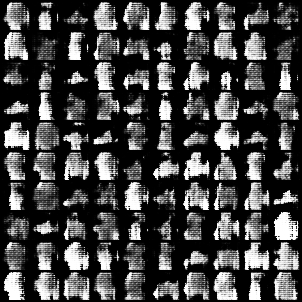

In [38]:
# show image generated by retrained lsgan
Image('/content/sample_data/Retrain_LSGAN/fake_images-0001.png')

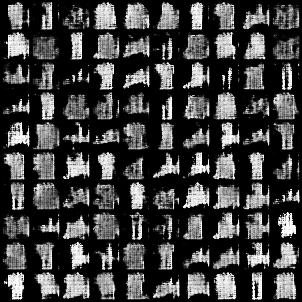

In [34]:
Image('/content/sample_data/Retrain_LSGAN/fake_images-0005.png')

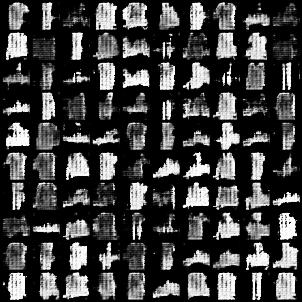

In [35]:
Image('/content/sample_data/Retrain_LSGAN/fake_images-0010.png')

Since LSGAN and DCGAN use different loss functions, the values of the losses from the two models are not comparable. However, for both models, the fake score and real score tend to converge around 0.5.

As both models have only run for 10 epochs, the underlying pattern may not be fully unveiled.

Based on the current experiments, in terms of the quality of generated images, personally, I think the DCGAN performs better than the LSGAN.